1. 데이터 불러오기/변환
2. Overview
  + [ ] 수집 체널 List
3. 당월자료 Summary : Graph
  + [ ] 유형별 수집자료 : 수치, 비율, 전월대비 증/감율
  + [x] Trend
  + [x] 비율
  + [ ] Wordcloud(A/B/C) : color 설정
  + [ ] 연관단어(keyword 기준)
3. 이메일 양식 작성

In [1]:
# DB접속
import pymysql
import pandas as pd
import numpy as np
import os

# from konlpy.tag import Okt
# okt = Okt("C:/Program Files/Java/jdk-12.0.1/bin/server/jvm.dll")

# 한글정제 KoNLPy
from ckonlpy.tag import Twitter
twitter = Twitter()

# 그래프
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)

# 분석1 : Trend 탐식 시, 이상치 확인
from sklearn.neighbors import LocalOutlierFactor

# 분석2 : wordcloud 준비
from wordcloud import WordCloud

# 분석3 : text rank 도출
import itertools
import nltk

# 시간기록
from datetime import datetime, timedelta
import time 
from dateutil.relativedelta import relativedelta

# 내용공유(e-mail, 회사) 
import send_email as se
from jinja2 import Template

import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [2]:
# 제품군 정보
category_group = '두유'
category_en = 'soymilk'
category = [['두유', '비리다'],
            ['두유', '냄새'  ], 
            ['두유', '맛없다'],
            ['두유', '밍밍'  ],
            ['두유', '달다'  ]
           ]

In [2]:
category_group = '상하목장'
category_en = 'sangha'
category = [['상하 우유',  '비리다'],
            ['상하 우유',  '냄새'  ],
            ['상하 우유',  '맛없다'],
            ['상하 우유',  '녹다'  ],
            ['아이스크림', '녹다'  ],
            ['아이스크림', '달다'  ],
            ['아이스크림', '파손'  ] ]

# 받는사람 : test 발송
to_users = ['khpark@maeil.com']

### I.데이터 불러오기

In [3]:
# 제품군 정보
df_product = pd.read_excel('./PRODUCT.xlsx','Sheet1')
df_product['PRODUCT_CODE'] = df_product['PRODUCT_CODE'].astype(object)
df_product = df_product[df_product['category1'] == category_group ]

In [4]:
query_values = tuple(df_product.PRODUCT_CODE.to_list())
query_values = str(query_values)

In [5]:
#########
# rawdata 불러오기
###

# DB연결
conn = pymysql.connect(host = '**.***.*.*', user ='__USER_ID__', password = "__PASSWORD__", database='__DATABASE__')

# cursor 설정
cursor = conn.cursor(pymysql.cursors.DictCursor)


In [87]:
# 쿼리실행: 전체리뷰
sql= '''select PRODUCT_CODE
        , (SELECT code_nm FROM JT_CODE B WHERE A.PRODUCT_CODE = B.CODE AND B.CODE_GRP_ID = 'PRODUCT')"상품명"
        , A.GRADE as "구매자평점" 
        , A.CONTENTS as 리뷰상세내용
        , (STR_TO_DATE(A.WRITE_DT, '%Y%m%d'))  as 리뷰등록일 
        , (SELECT CODE_NM FROM JT_CODE B WHERE A.COMPANY_CODE = B.CODE AND B.CODE_GRP_ID = 'DEALER_ID') as 수집채널 
        FROM MAEIL_REVIEW A
        where GRADE in (1,2,3,4,5)
        and PRODUCT_CODE in ''' + query_values + '''and DATE_FORMAT(substr(A.WRITE_DT, 1,8), '%Y/%m/%d') between LAST_DAY(NOW() - interval 1 month) + interval 1 DAY and DATE_ADD(curdate(),INTERVAL -1 day)
        group by A.COMPANY_CODE, A.WRITER, A.CONTENTS, A.WRITE_DT, A.GRADE, A.PRODUCT_CODE
        order by A.WRITE_DT desc
        '''
cursor.execute(sql)
df_review_all = cursor.fetchall()
df_review_all = pd.DataFrame(df_review_all)
df_review_all['리뷰등록일'] = pd.to_datetime(df_review_all['리뷰등록일'])
df_review_all = df_review_all.join(df_product.set_index('상품명')['category2'], on='상품명')

df_review_all = df_review_all[df_review_all.columns[2:]].drop_duplicates().reset_index(drop=True)

df_review_all['리뷰등록일'] = df_review_all['리뷰등록일'].dt.strftime('%m/%d')

df_review_all = df_review_all.replace('25 카카오 톡스토어(20.12.2~미사용)', '25 카카오톡')

df_review_all['구매자평점'] = df_review_all['구매자평점'].astype('int')

# if category_group == '상하목장':
df_review_2= pd.read_excel('./kurly_review.xlsx','Sheet1')
df_review_2 = df_review_2[['구매자평점', '리뷰상세내용', '리뷰등록일', '수집채널', 'category2']]
df_review_2['리뷰등록일'] = pd.to_datetime(df_review_2['리뷰등록일'])
df_review_2['리뷰등록일'] = df_review_2['리뷰등록일'].dt.strftime('%m/%d')
df_review_2['구매자평점'] = df_review_2['구매자평점'].astype('int')

df_review_all= pd.concat([df_review_all,df_review_2],axis=0, ignore_index=True)
df_review_all['구매자평점'] = df_review_all['구매자평점'].astype('object')


In [82]:
# if category_group == '상하목장':
#     df_review_2= pd.read_excel('./kurly_review.xlsx','Sheet1')
#     # df_review_2.head()
#     df_review_2 = df_review_2[['구매자평점', '리뷰상세내용', '리뷰등록일', '수집채널', 'category2']]
#     df_review_2['리뷰등록일'] = pd.to_datetime(df_review_2['리뷰등록일'])
#     df_review_2['리뷰등록일'] = df_review_2['리뷰등록일'].dt.strftime('%m/%d')
#     df_review_2['구매자평점'] = df_review_2['구매자평점'].astype('int')
    
#     df_review_all= pd.concat([df_review_all,df_review_2],axis=0, ignore_index=True)
#     df_review_all.reset_index()
#     df_review_all['구매자평점'] = df_review_all['구매자평점'].astype('object')
# else:
#     pass

In [84]:
df_review_all

,PRODUCT_CODE,상품명,구매자평점,리뷰상세내용,리뷰등록일,수집채널,category2
0,910605,상하목장 피노 얼려먹는 아이스크림 [ NEW ] [ 밀크 ] [ 85ML X 24 ],5,"진한 우유맛, 쫀득쫀득 좋아요",08/16,3 네이버,아이스크림
1,106295,상하목장 얼려먹는 아이스크림 [ 밀크 ],5,아이가 엄청 맛있다고 하네요~,08/16,3 네이버,아이스크림
2,910605,상하목장 피노 얼려먹는 아이스크림 [ NEW ] [ 밀크 ] [ 85ML X 24 ],5,아이가 엄청 맛있다고 하네요~,08/16,3 네이버,아이스크림
3,106295,상하목장 얼려먹는 아이스크림 [ 밀크 ],5,맛있고 먹기 편리해요! 아이가 좋아해요 +.+,08/16,3 네이버,아이스크림
4,910605,상하목장 피노 얼려먹는 아이스크림 [ NEW ] [ 밀크 ] [ 85ML X 24 ],5,맛있고 먹기 편리해요! 아이가 좋아해요 +.+,08/16,3 네이버,아이스크림
...,...,...,...,...,...,...,...
8343,NaN,NaN,5,\n살짝 녹여서 컵에다 으깨서 부드럽게 먹으니 참 맛있네요^^ \n여름날 식 후 디...,08/13,마켓컬리,아이스크림
8344,NaN,NaN,5,\n아이가 좋아해요 맛있데요,08/13,마켓컬리,아이스크림
8345,NaN,NaN,5,\n올여름은 아이스주스 망고 덕에 시원하게 나는 중! \n엄마가 더 찾으셔서 냉동실...,08/13,마켓컬리,아이스크림
8346,NaN,NaN,5,\n아이들 간식으로 구매했어요.,08/13,마켓컬리,아이스크림


In [ ]:
df_review_all

In [8]:
# 쿼리실행: 전월동기
sql2= '''select PRODUCT_CODE
        , (SELECT code_nm FROM JT_CODE B WHERE A.PRODUCT_CODE = B.CODE AND B.CODE_GRP_ID = 'PRODUCT')"상품명"
        , A.GRADE as "구매자평점" 
        , A.CONTENTS as 리뷰상세내용
        , (STR_TO_DATE(A.WRITE_DT, '%Y%m%d'))  as 리뷰등록일 
        , (SELECT CODE_NM FROM JT_CODE B WHERE A.COMPANY_CODE = B.CODE AND B.CODE_GRP_ID = 'DEALER_ID') as 수집채널 
        FROM MAEIL_REVIEW A
        where GRADE in (1,2,3,4,5)
        and PRODUCT_CODE in ''' + query_values + '''and DATE_FORMAT(substr(A.WRITE_DT, 1,8), '%Y/%m/%d') between LAST_DAY(NOW() - interval 2 month) + interval 1 DAY and DATE_ADD(curdate(),INTERVAL -1 day)- interval 1 month
        group by A.COMPANY_CODE, A.WRITER, A.CONTENTS, A.WRITE_DT, A.GRADE, A.PRODUCT_CODE
        order by A.WRITE_DT
        '''
cursor.execute(sql2)
df_review_all_before = cursor.fetchall()

#데이터 속성변경
df_review_all_before = pd.DataFrame(df_review_all_before)
df_review_all_before['리뷰등록일'] = pd.to_datetime(df_review_all_before['리뷰등록일'])
df_review_all_before['리뷰등록일'] = df_review_all_before['리뷰등록일'].dt.strftime('%m/%d')
df_review_all_before = df_review_all_before.replace('25 카카오 톡스토어(20.12.2~미사용)', '25 카카오톡')

#데이터 정렬
df_review_all_before = df_review_all_before.join(df_product.set_index('상품명')['category2'], on='상품명')
df_review_all_before = df_review_all_before[df_review_all_before.columns[2:]].drop_duplicates().reset_index(drop=True)

In [89]:
###############
# Text 정제
#####

# 사전에 고유 명사 추가
twitter.add_dictionary('셀렉스', 'Noun')
twitter.add_dictionary('무설탕', 'Noun')
twitter.add_dictionary('프로틴', 'Noun')
twitter.add_dictionary('보냉백', 'Noun')
twitter.add_dictionary('라방', 'Noun')
twitter.add_dictionary('재구매', 'Noun')
twitter.add_dictionary('유통기한', 'Noun')
twitter.add_dictionary('사은품', 'Noun')
twitter.add_dictionary('아몬드브리즈', 'Noun')
twitter.add_dictionary('팥빙수', 'Noun')

def tokenize(doc):
    result = ['/'.join(t) for t in twitter.pos(doc, norm=True, stem=True)] # ex '더빙/Norm', '나다/Verb'
    return result 

def listToString(s):  
    str1 = ""  
    for ele in s:  
        str1 += " " + ele.strip()  
    return str1


In [114]:
#토큰화 : 전체리뷰자료
df_temp1 = df_review_all['리뷰상세내용'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# regex to konlpy
token_all = [tokenize(row) for row in df_temp1 ]  


In [10]:

data_trim2 = []
for i in range(len(df_temp1)):
    t = ' '.join(token_all[i])
    data_trim2.append(t.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]",""))
    
df_temp1 = pd.DataFrame(data_trim2)
df_temp1 = df_temp1[0].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

df_review_all['token'] = df_temp1
df_review_all['token_attribution'] = token_all

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
#토큰화 : 전월동기
df_temp1 = df_review_all_before['리뷰상세내용'].replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# regex to konlpy
token_all = [tokenize(row) for row in df_temp1 ]  

data_trim2 = []
for i in range(len(df_temp1)):
    t = ' '.join(token_all[i])
    data_trim2.append(t.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]",""))
    
df_temp1 = pd.DataFrame(data_trim2)
df_temp1 = df_temp1[0].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

df_review_all_before['token'] = df_temp1
df_review_all_before['token_attribution'] = token_all

In [ ]:
###############
# 데이터 유형 분류
#####

# 당월 긍정/중립/부정 리뷰
df_review_pos= df_review_all[(df_review_all['구매자평점']=='4')|(df_review_all['구매자평점']=='5')]
df_review_nue= df_review_all[(df_review_all['구매자평점']=='3')]
df_review_neg= df_review_all[(df_review_all['구매자평점']=='1')|(df_review_all['구매자평점']=='2')]

# 전월 긍정/중립/부정 리뷰
df_review_pos_before= df_review_all_before[(df_review_all_before['구매자평점']=='4')|(df_review_all_before['구매자평점']=='5')]
df_review_nue_before= df_review_all_before[(df_review_all_before['구매자평점']=='3')]
df_review_neg_before= df_review_all_before[(df_review_all_before['구매자평점']=='1')|(df_review_all_before['구매자평점']=='2')]


In [89]:
# print('<<기간 내 리뷰수>>' )
# print(' - 긍정(54   ) : {:,.0f}'.format(len(df_review_pos)) )
# print(' - 중립(  3  ) : {:,.0f}'.format(len(df_review_nue)) )
# print(' - 부정(   21) : {:,.0f}'.format(len(df_review_neg)) )

In [90]:
# print('<<기간 내 리뷰수 비중>>' )
# print(' - 긍정(54   ) : {:,.1f}%'.format(len(df_review_pos)/len(df_review_all)*100 ) )
# print(' - 중립(  3  ) : {:,.1f}%'.format(len(df_review_nue)/len(df_review_all)*100 ) )
# print(' - 부정(   21) : {:,.1f}%'.format(len(df_review_neg)/len(df_review_all)*100 ) )

In [39]:
# print('<<기간 내 리뷰 증감률>>' )
print(' - 전체(54321) : {:,.1f}%'.format( (len(df_review_all)-len(df_review_all_before))/len(df_review_all_before)*100 ) )
print(' - 긍정(54   ) : {:,.1f}%'.format( (len(df_review_pos)-len(df_review_pos_before))/len(df_review_pos_before)*100 ) )
print(' - 중립(  3  ) : {:,.1f}%'.format( (len(df_review_nue)-len(df_review_nue_before))/len(df_review_nue_before)*100 ) )
print(' - 부정(   21) : {:,.1f}%'.format( (len(df_review_neg)-len(df_review_neg_before))/len(df_review_neg_before)*100 ) )

 - 전체(54321) : -9.4%
 - 긍정(54   ) : -8.7%
 - 중립(  3  ) : -35.2%
 - 부정(   21) : -45.5%


['5', '4', '3', '1', '2']

### III.데이터 리포팅

In [42]:
###############
# 리포트용 자료 만들기 : 1.제품 현황
#####

#당월 날짜 생성
start = (datetime.today().replace(day=1)).strftime('%Y/%m/%d')
end = ((datetime.today()+relativedelta(months=1)).replace(day=1)-timedelta(days=1)).strftime('%Y/%m/%d')
monthly_date = [d.strftime('%m/%d') for d in pd.date_range(start, end, freq='D')]


trend_review_all = pd.pivot_table(df_review_all, index = '리뷰등록일', values = '리뷰상세내용', columns = '구매자평점', aggfunc = 'count').fillna(0)

trend_review_pos = pd.pivot_table(df_review_pos, index = '리뷰등록일', values = '리뷰상세내용', aggfunc = 'count').fillna(0)
trend_review_nue = pd.pivot_table(df_review_nue, index = '리뷰등록일', values = '리뷰상세내용', aggfunc = 'count').fillna(0)
trend_review_neg = pd.pivot_table(df_review_neg, index = '리뷰등록일', values = '리뷰상세내용', aggfunc = 'count').fillna(0)

REPORT = pd.DataFrame()
REPORT['리뷰등록일'] = monthly_date
REPORT_01 = pd.merge(REPORT, trend_review_pos, left_on=['리뷰등록일'], right_on=trend_review_pos.index, how='outer')
REPORT_01.rename(columns = { '리뷰상세내용' : '긍정리뷰' }, inplace = True)

REPORT_01 = pd.merge(REPORT_01, trend_review_nue, left_on=['리뷰등록일'], right_on=trend_review_nue.index, how='outer')
REPORT_01.rename(columns = { '리뷰상세내용' : '중립리뷰' }, inplace = True)

REPORT_01 = pd.merge(REPORT_01, trend_review_neg, left_on=['리뷰등록일'], right_on=trend_review_neg.index, how='outer')
REPORT_01.rename(columns = { '리뷰상세내용' : '부정리뷰' }, inplace = True)
# REPORT_01 = REPORT_01.fillna('')

REPORT_01['리뷰등록일'] = REPORT_01['리뷰등록일'].str.slice(start=-5)
REPORT_01['리뷰등록일'] = REPORT_01['리뷰등록일'].str.replace('-', '/')

In [111]:
# word cloud 생성 모듈
def wordcloud_gen(dataset, color):
    text = dataset.to_list()
    text_all = listToString(text)
    wc1 = WordCloud(font_path= path, stopwords = stopword, width = 600, height = 600, background_color="white", repeat=True, colormap = color)
    return wc1.generate(text_all)


stopword = ['먹다', '하다', '좋다'  , '예요', '이에요', '있다', '맛있다', '같다', '없다', '보통', '최고', '주문', '보다', '매일',
         '구매', '에서', '먹이다', '않다', '자다'  , '들다', '사다'  , '되다', '으로', 'ㅠㅠ', 'ㅜㅜ', '말다', '이다', '받다',
         '아직', '이다', '보이다', '이나', '오다'  , '이라', '우유'  , '배달', '배송', '가정', '제품', '신청', '문의', '되어다',
         '넘다', 'ㅋㅋ', 'ㅋㅋㅋ', 'ㅎㅎ', '진짜'  , '너무', '이', '는', '요', '은', '에', '기', '다', '도', '원', '구', '개', '랑','가',
         '도', '임시', '이미지', '확인', '후', '을', '안' ,'되다', '하', '심', '고객', '님', '어요', '좀', '것', '니', '어보', '타',
         '생각', '지만', '잘', '제', '니다', '네', '해', '그래도', '엄청', '하고', '번', '그', '나다', '시', '다가', '한', '해서', '로',
         '더', '못', '에는', '던데', '일단', '나요', '아하', '이적','이고', '려고', '이라고', '고', '어서','를', '그냥', '만', '짧다',
         '유통기한', '인데', '박스', '까지', '일', '월', '두', '팩','어요', '요','다', '한', '있다', '라', '나', '게', '거', '데',
         '더니','달', '보', '이번', '이네', '내주', '하나', '수', '저', '이렇다', '이렇게', 'ㅠ', '때', '늘', '또', '편', '늘','감사',
         '항상', '여', '아해', '들', '중', '열', '영', '분', '세', '뭐', '루', '알', '용', '통', '함', '무', '생', '물', '리', '새',
         '적', 'hellip'
         ]

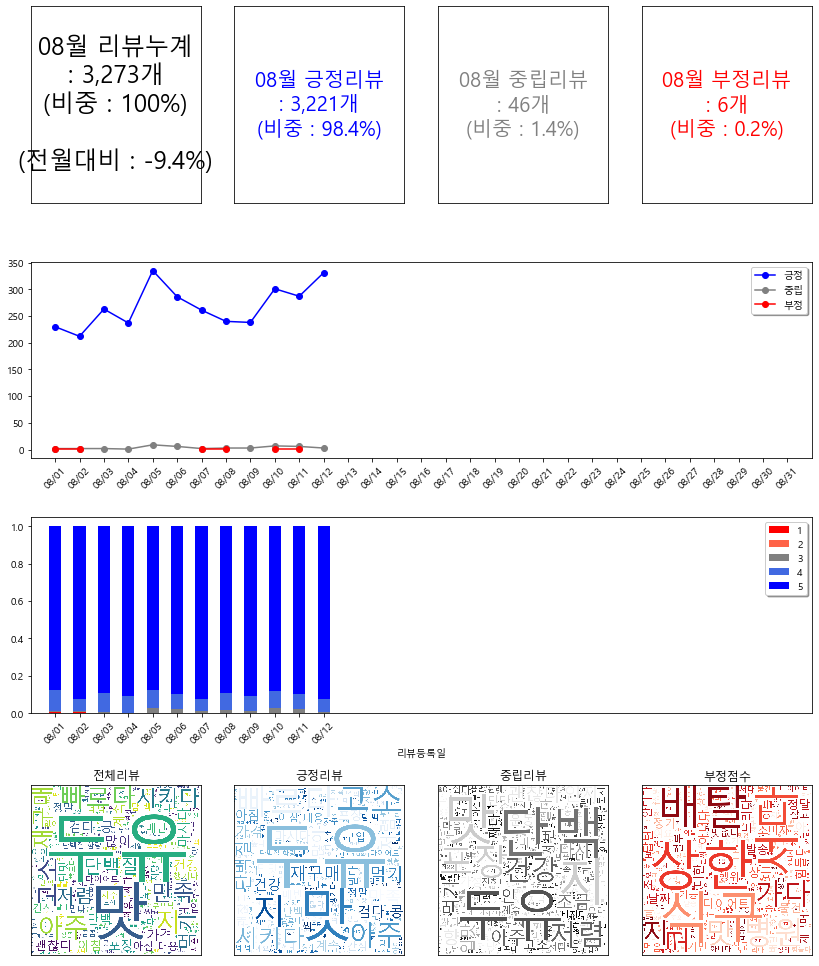

In [146]:
# 그래프 생성
date2 = datetime.today().strftime('%Y%m%d')
image_name = date2[2:] +'_cs_Trend_graph.png'

fig = plt.figure(figsize=(14, 30))

###############
# 당월 리뷰내용 요약
#####
ax1 = plt.subplot2grid((7, 4), (0, 0))
plt.xticks([]); plt.yticks([]); plt.grid(False)
plt.axis([0, 2, 0, 2])
plt.text(1, 1, ha = 'center', va = 'center', fontsize =24, 
         s='{}월 리뷰누계\n: {:,.0f}개\n(비중 : {:,.0f}%)'.format(datetime.now().strftime('%m'), 
                                                                  len(df_review_all), len(df_review_all)/len(df_review_all)*100 )

ax2 = plt.subplot2grid((7, 4), (0, 1))
plt.xticks([]); plt.yticks([]); plt.grid(False)
plt.axis([0, 2, 0, 2])
plt.text(1, 1, ha = 'center', va = 'center', fontsize =20, c = 'blue', 
         s='{}월 긍정리뷰\n: {:,.0f}개\n(비중 : {:,.1f}%)'.format(datetime.now().strftime('%m'), len(df_review_pos),len(df_review_pos)/len(df_review_all)*100 ) )

ax3 = plt.subplot2grid((7, 4), (0, 2))
plt.xticks([]); plt.yticks([]); plt.grid(False)
plt.axis([0, 2, 0, 2])
plt.text(1, 1, ha = 'center', va = 'center', fontsize =20, c = 'gray',
         s='{}월 중립리뷰\n: {:,.0f}개\n(비중 : {:,.1f}%)'.format( datetime.now().strftime('%m'), len(df_review_nue),len(df_review_nue)/len(df_review_all)*100 ) )

ax4 = plt.subplot2grid((7, 4), (0, 3))
plt.xticks([]); plt.yticks([]); plt.grid(False)
plt.axis([0, 2, 0, 2])
plt.text(1, 1, ha = 'center', va = 'center', fontsize =20, c = 'red',
         s='{}월 부정리뷰\n: {:,.0f}개\n(비중 : {:,.1f}%)'.format( datetime.now().strftime('%m'), len(df_review_neg),len(df_review_neg)/len(df_review_all)*100 ) )     


###############
# 일별 리뷰내용 추이
#####
ax5 = plt.subplot2grid((7, 4), (1, 0), colspan=4)
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.3)
plt.plot(REPORT_01.리뷰등록일, REPORT_01.긍정리뷰, marker="o", color= 'blue', label='긍정')
plt.plot(REPORT_01.리뷰등록일, REPORT_01.중립리뷰, marker="o", color= 'gray', label='중립')
plt.plot(REPORT_01.리뷰등록일, REPORT_01.부정리뷰, marker="o", color= 'red',  label='부정')
lgd = plt.legend(loc='best',fancybox=True, shadow=True)
plt.xticks(rotation=45)
plt.xlim(-1,31)


###############
# 일별 리뷰내용 비율
#####
ax6 = plt.subplot2grid((7, 4), (2, 0), colspan=4)
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.3)
colors = ['red', 'tomato', 'gray', 'royalblue', 'blue' ]
pd.crosstab(df_review_all.리뷰등록일, df_review_all.구매자평점, normalize='index').plot.bar(stacked=True,  ax = ax6, color=colors)
lgd = plt.legend(loc='best',fancybox=True, shadow=True)
plt.xlim(-1,31)
plt.xticks(rotation=45)

###############
# word cloud
#####

ax7 = plt.subplot2grid((7, 4), (3, 0))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.3)
plt.xticks([]); plt.yticks([]); plt.grid(False)
plt.imshow(wordcloud_gen(df_review_all['token'], None), cmap=plt.cm.binary)
plt.title('전체리뷰',fontsize='large')

ax8 = plt.subplot2grid((7, 4), (3, 1))
plt.xticks([]); plt.yticks([]); plt.grid(False)
plt.imshow(wordcloud_gen(df_review_pos['token'], 'Blues_r'), cmap=plt.cm.binary)
plt.title('긍정리뷰',fontsize='large')

ax9 = plt.subplot2grid((7, 4), (3, 2))
plt.xticks([]); plt.yticks([]); plt.grid(False)
plt.imshow(wordcloud_gen(df_review_nue['token'], 'gray'), cmap=plt.cm.binary)
plt.title('중립리뷰',fontsize='large')

ax10 = plt.subplot2grid((7, 4), (3, 3))
plt.xticks([]); plt.yticks([]); plt.grid(False)
try:
    plt.imshow(wordcloud_gen(df_review_neg['token'], 'Reds'), cmap=plt.cm.binary)
except:
    pass
plt.title('부정점수',fontsize='large')

# plt.savefig(image_name, bbox_inches='tight', dpi=70)

plt.show()

In [132]:
list_pos_termA = list(itertools.chain(*df_review_pos.token_attribution))
list_pos_termB = list(itertools.chain(*df_review_pos_before.token_attribution))

list_nue_termA = list(itertools.chain(*df_review_nue.token_attribution))
list_nue_termB = list(itertools.chain(*df_review_nue_before.token_attribution))

list_neg_termA = list(itertools.chain(*df_review_neg.token_attribution))
list_neg_termB = list(itertools.chain(*df_review_neg_before.token_attribution))

In [133]:
def wordrank(dataset):
    ko = nltk.Text(dataset)
    
    data = ko.vocab().items()
    reviw_word_all = pd.DataFrame.from_dict(data)
    reviw_word_all.rename(columns = { 1 : 'count' }, inplace = True)
    reviw_word_all = reviw_word_all.sort_values('count', ascending=False)
    reviw_word_all['속성'] =reviw_word_all[0].str.split('/').str[1]
    reviw_word_all['내용'] =reviw_word_all[0].str.split('/').str[0]

    # stopword 내용 삭제
    reviw_word_all = reviw_word_all[~reviw_word_all.내용.isin(stopword)]

    # 일부 속성 삭제
    reviw_word_all = reviw_word_all[(reviw_word_all['속성']!=  'Punctuation')]
    reviw_word_all = reviw_word_all[(reviw_word_all['속성']!=  'Josa')]
    reviw_word_all = reviw_word_all[(reviw_word_all['속성']!=  'Foreign')]
    reviw_word_all = reviw_word_all[(reviw_word_all['속성']!=  'KoreanParticle')]
    reviw_word_all = reviw_word_all[(reviw_word_all['속성']!=  'Number')]
    reviw_word_all = reviw_word_all[(reviw_word_all['속성']!=  'Adverb')]
    reviw_word_all = reviw_word_all[(reviw_word_all['속성']!=  'Exclamation')]

    # top15 만 지정
    reviw_word_all = reviw_word_all[['속성', '내용', 'count']]

    return reviw_word_all

In [136]:
wordrank_pos_termA = wordrank(list_pos_termA)
wordrank_pos_termA['기간구분'] = '당월(A)'
wordrank_pos_termA['리뷰시점'] = df_review_pos.리뷰등록일.max()
wordrank_pos_termA['RANK'] = wordrank_pos_termA['count'].rank(ascending = False)

wordrank_pos_termB = wordrank(list_pos_termB)
wordrank_pos_termB['기간구분'] = '전월(B)'
wordrank_pos_termB['리뷰시점'] = df_review_pos_before.리뷰등록일.max()
wordrank_pos_termB['RANK'] = wordrank_pos_termB['count'].rank(ascending = False)

wordrank_nue_termA = wordrank(list_nue_termA)
wordrank_nue_termA['기간구분'] = '당월(A)'
wordrank_nue_termA['리뷰시점'] = df_review_nue.리뷰등록일.max()
wordrank_nue_termA['RANK'] = wordrank_nue_termA['count'].rank(ascending = False)

wordrank_nue_termB = wordrank(list_nue_termB)
wordrank_nue_termB['기간구분'] = '전월(B)'
wordrank_nue_termB['리뷰시점'] = df_review_nue_before.리뷰등록일.max()
wordrank_nue_termB['RANK'] = wordrank_nue_termB['count'].rank(ascending = False)

wordrank_neg_termA = wordrank(list_neg_termA)
wordrank_neg_termA['기간구분'] = '당월(A)'
wordrank_neg_termA['리뷰시점'] = df_review_neg.리뷰등록일.max()
wordrank_neg_termA['RANK'] = wordrank_neg_termA['count'].rank(ascending = False)

wordrank_neg_termB = wordrank(list_neg_termB)
wordrank_neg_termB['기간구분'] = '전월(B)'
wordrank_neg_termB['리뷰시점'] = df_review_neg_before.리뷰등록일.max()
wordrank_neg_termB['RANK'] = wordrank_neg_termB['count'].rank(ascending = False)


wordrank_pos = pd.concat([wordrank_pos_termA, wordrank_pos_termB])
wordrank_nue = pd.concat([wordrank_nue_termA, wordrank_nue_termB])
wordrank_neg = pd.concat([wordrank_neg_termA, wordrank_neg_termB])

# wordrank_total = pd.concat([wordrank_all, wordrank_neg])

REPORT_03_pos =  pd.pivot_table(wordrank_pos, values='RANK', index=['내용'], columns=['기간구분'],  aggfunc=np.min)
REPORT_03_nue =  pd.pivot_table(wordrank_nue, values='RANK', index=['내용'], columns=['기간구분'],  aggfunc=np.min)
REPORT_03_neg =  pd.pivot_table(wordrank_neg, values='RANK', index=['내용'], columns=['기간구분'],  aggfunc=np.min)


REPORT_03_pos = wordrank_pos_termA.head(15).merge(REPORT_03_pos, how='left', on=['내용'])
REPORT_03_pos = REPORT_03_pos[['속성', '내용', '당월(A)', '전월(B)']]

REPORT_03_nue = wordrank_nue_termA.head(15).merge(REPORT_03_nue, how='left', on=['내용'])
REPORT_03_nue = REPORT_03_nue[['속성', '내용', '당월(A)', '전월(B)']]

REPORT_03_neg = wordrank_neg_termA.head(15).merge(REPORT_03_neg, how='left', on=['내용'])
REPORT_03_neg = REPORT_03_neg[['속성', '내용', '당월(A)', '전월(B)']]


In [138]:
REPORT_03_pos['diff'] = REPORT_03_pos['당월(A)'] - REPORT_03_pos['전월(B)']
REPORT_03_nue['diff'] = REPORT_03_nue['당월(A)'] - REPORT_03_nue['전월(B)']
REPORT_03_neg['diff'] = REPORT_03_neg['당월(A)'] - REPORT_03_neg['전월(B)']

In [156]:
# fig = plt.figure(figsize=(14, 30))

def rank_graph(REPORT,dataset ):
    word = list(REPORT['내용'].head(15))
    arrow_lengths = list(REPORT['diff'].head(15))
    for i, v in enumerate(word):
        temp = dataset[dataset['내용'] == v ]
        if arrow_lengths[i] > 0:
            arrow_color = 'red'
            arrow_marker = 'o'
        elif arrow_lengths[i] < 0:
            arrow_color = 'blue'
            arrow_marker = '>'
        else:
            arrow_color = 'gray'
            arrow_marker = 'o'
        plt.plot(temp.기간구분, temp.RANK, color=arrow_color, marker=arrow_marker, markersize=8)
        plt.text(0-0.05, 
                 temp.RANK.values[0], 
                 '{:,.0f}'.format(temp.RANK.values[0])+' '+ v , va='center' )
        try:
            plt.text(1+0.05, temp.RANK.values[1], '{:,.0f}'.format(temp.RANK.values[1]), va='center', ha='right')
        except:
            pass
    yticks = plt.yticks()[0]
    plt.ylim(0,16)
    plt.yticks([])
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    # plt.title('GDP Per Capta\n', loc='left', fontsize=20)
    ax.xaxis.grid(color='black', linestyle='solid', 
                  which='both', alpha=0.9)
    # remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)

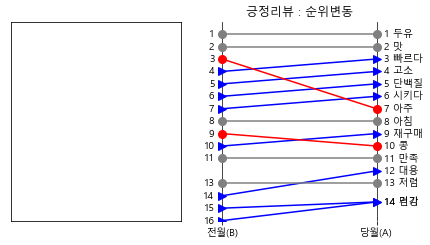

In [172]:
fig = plt.figure(figsize=(14, 30))

ax15 = plt.subplot2grid((7, 4), (1, 0))
plt.xticks([]); plt.yticks([])

ax = plt.subplot2grid((7, 4), (1, 1))
plt.title('긍정리뷰 : 순위변동',fontsize='large')
rank_graph(REPORT_03_pos,wordrank_pos)



NameError: name 'ax' is not defined

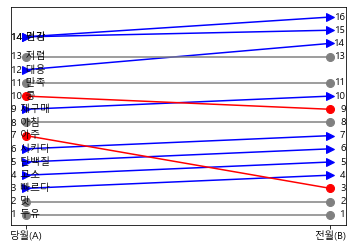

In [147]:
REPORT = REPORT_03_pos
dataset = wordrank_pos
word = list(REPORT['내용'].head(15))
arrow_lengths = list(REPORT['diff'].head(15))
for i, v in enumerate(word):
    temp = dataset[dataset['내용'] == v ]
    if arrow_lengths[i] > 0:
        arrow_color = 'red'
        arrow_marker = 'o'
    elif arrow_lengths[i] < 0:
        arrow_color = 'blue'
        arrow_marker = '>'
    else:
        arrow_color = 'gray'
        arrow_marker = 'o'
    plt.plot(temp.기간구분, temp.RANK, color=arrow_color, marker=arrow_marker, markersize=8)
    plt.text(0-0.05, 
             temp.RANK.values[0], 
             '{:,.0f}'.format(temp.RANK.values[0])+' '+ v , va='center' )
    try:
        plt.text(1+0.05, temp.RANK.values[1], '{:,.0f}'.format(temp.RANK.values[1]), va='center', ha='right')
    except:
        pass
yticks = plt.yticks()[0]
plt.ylim(0,16)
plt.yticks([])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
# plt.title('GDP Per Capta\n', loc='left', fontsize=20)
lgd = plt.legend(word, loc='lower center', bbox_to_anchor=(0.5, -0.4), fancybox=True, shadow=True, ncol=4)

In [112]:

###############
# 리포트용 자료 만들기 : 4.최근 리뷰 rawdata : 긍정/부정 상위 10개만
#####

REPORT_02 = df_review_pos.head(10)
REPORT_02 = REPORT_02[['수집채널', 'category2', '리뷰상세내용', '구매자평점', '리뷰등록일']]


REPORT_03 = df_review_nue.head(10)
REPORT_03 = REPORT_03[['수집채널', 'category2', '리뷰상세내용', '구매자평점', '리뷰등록일']]


REPORT_04 = df_review_neg.head(10)
REPORT_04 = REPORT_04[['수집채널', 'category2', '리뷰상세내용', '구매자평점', '리뷰등록일']]



In [113]:
###############
# 리포트용 자료 만들기 : 3.키워드별 rawdata
#####

data_by_keyword = pd.DataFrame()

category_count = []
for text1 ,text2 in category :
    df_sort = df_review_all[(df_review_all['token'].str.contains(str(text2)))]
    df_sort = df_sort[(df_sort['category2'].str.contains(str(text1)))][['리뷰등록일','수집채널','리뷰상세내용','구매자평점', 'category2']]
    df_sort = df_sort.drop_duplicates()
    if len(df_sort) > 0:
        df_sort['키워드'] = text2
        category_count.append(len(df_sort))
        data_by_keyword = pd.concat([df_sort, data_by_keyword]) 
    else:
        category_count.append(int(0))


In [562]:

##########
# Excel 파일 생성(using XlsxWriter)
###

date2 = datetime.today().strftime('%Y%m%d')
date2 = date2[2:]
excel_name = date2 +'_' + category_en + '_report.xlsx'
writer = pd.ExcelWriter(excel_name, engine='xlsxwriter')


# 1.긍정리뷰 : 상위내용만
REPORT_02.to_excel(writer, sheet_name='1.긍정정리뷰)')

# 2.중립리뷰 : 상위내용만
REPORT_03.to_excel(writer, sheet_name='2.중립리뷰)')

# 3.부정리뷰
df_review_neg.to_excel(writer, sheet_name='3.부정리뷰)')


# 4.키워드별 리뷰내용
data_by_keyword.to_excel(writer, sheet_name='4.키워드기준 리뷰')


writer.save()
writer.close()


In [ ]:
###############
# 이메일 발송
#####


# 이메일 양식(내용) frame 구성하기
message_tmpl="""
<html>
    <!DOCTYPE html>
    <html>
    <head lang ="ko">
      <meta charset ="UTF-8">
      <title>{{title1}}</title>
    </head>
    <BODY style="FONT-SIZE: 10pt; font-family: 맑은고딕, Malgun Gothic, NanumGothic, gulim, sans-serif">
    안녕하세요,<br>
    <br>
    {{send_date}}기준, [{{category}}] 제품군에 대한 리뷰자료 요약내용 공유드립니다.<br>
    (매주 월요일, 오전 9시 30~35분 사이 발송)<br>
    <br>
    <b>1. summary</b><br>
    - 수집된 체널 : {{channel}}<br>
    <img src="cid:image1"><br>
    <br>
    <br>
    <b>2. 긍정리뷰 : 최근 10개</b><br>
    {{ df2_html }}<br>
    <br>
    <br>
    <b>3. 중립리뷰 : 최근 10개</b><br>
    {{ df3_html }}<br>
    <br>
    <br>
    <br>
    <b>4. 부정리뷰 : 최근 10개</b><br>
    {{ df4_html }}<br>
    <br>
    <br>
    <SPAN style="COLOR: #808080">{{title3_text2}}</SPAN><br>
    <SPAN style="COLOR: #808080">{{title3_text3}}</SPAN><br>
    <br>
    <br>
    감사합니다.<br>
    <br>
    </BODY>
</html>"""

# 이메일 양식(내용) 변동 내용 정의
render_data = {
    'send_date' : (datetime.today()).strftime('%m/%d'),
    'send_weekday' : (datetime.today()).strftime('%Y, %W')+'주',
    'category' : category_group,
    'channel'  : df_review_all.수집채널.unique(),
    'df2_html' : REPORT_02.to_html(),
    'df3_html' : REPORT_03.to_html(),
    'df4_html' : REPORT_04.to_html(),
    'add_text1' : "**  본 메일은 발신전용입니다.",
    'add_text2' : "*** (내용/기술문의 : 고객정보전략담당, 박경하 )"
}

t= Template(message_tmpl)
html_report = t.render(render_data)



# 메일제목
now = datetime.today()    # 현재
date = now.strftime('%Y%m%d')

subject = "[" + category_group + "] "+date[2:] + "_리뷰 현황(발송전용)_v3.2"

# 본문
html = html_report

# 첨부파일 추가
try:
    attach = './' + excel_name
except:
    attach  = None

try:
    graph  = './' + image_name
except:
    graph  = None


# 이메일 발송
se.send_email(to_users, subject, html,  graph, attach)

os.remove(graph)
os.remove(excel_name)